In [2]:
from datetime import datetime
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline

# 2. Exploratory Weather Data Analysis
This analysis will use daily weather data created in [part one](#) and will focus on:

1. Quantifying the "missingness" of weather and precipitation measurements produced by weather stations in London Ontario
2. Identify relationships between weather and precipitation variables
3. Visualizing how weather and precipitation are changing over time

As this is an EDA (exploratory data analysis), emphasis will be placed on graphical rather than statisical representations of the data in the hopes (and expectation) that readers will be able to better identify better with the data through visualization than with the raw numbers.

## 2.1 Data

In [23]:
df = pd.read_csv("../data/notebook1_weather_by_day_2017-08-25 00:00:00.csv", parse_dates=['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2794 entries, 0 to 2793
Data columns (total 15 columns):
date                  2794 non-null datetime64[ns]
maxTemp               2792 non-null float64
minTemp               2793 non-null float64
meanTemp              2792 non-null float64
heatDegDays           2792 non-null float64
coolDegDays           2792 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2754 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1987 non-null float64
season                2794 non-null object
year                  2794 non-null int64
month                 2794 non-null int64
dtypes: datetime64[ns](1), float64(11), int64(2), object(1)
memory usage: 327.5+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,season,year,month
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,winter,2010,1
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,winter,2010,1
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,winter,2010,1
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,winter,2010,1
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,winter,2010,1


## 2.2 Missing Values

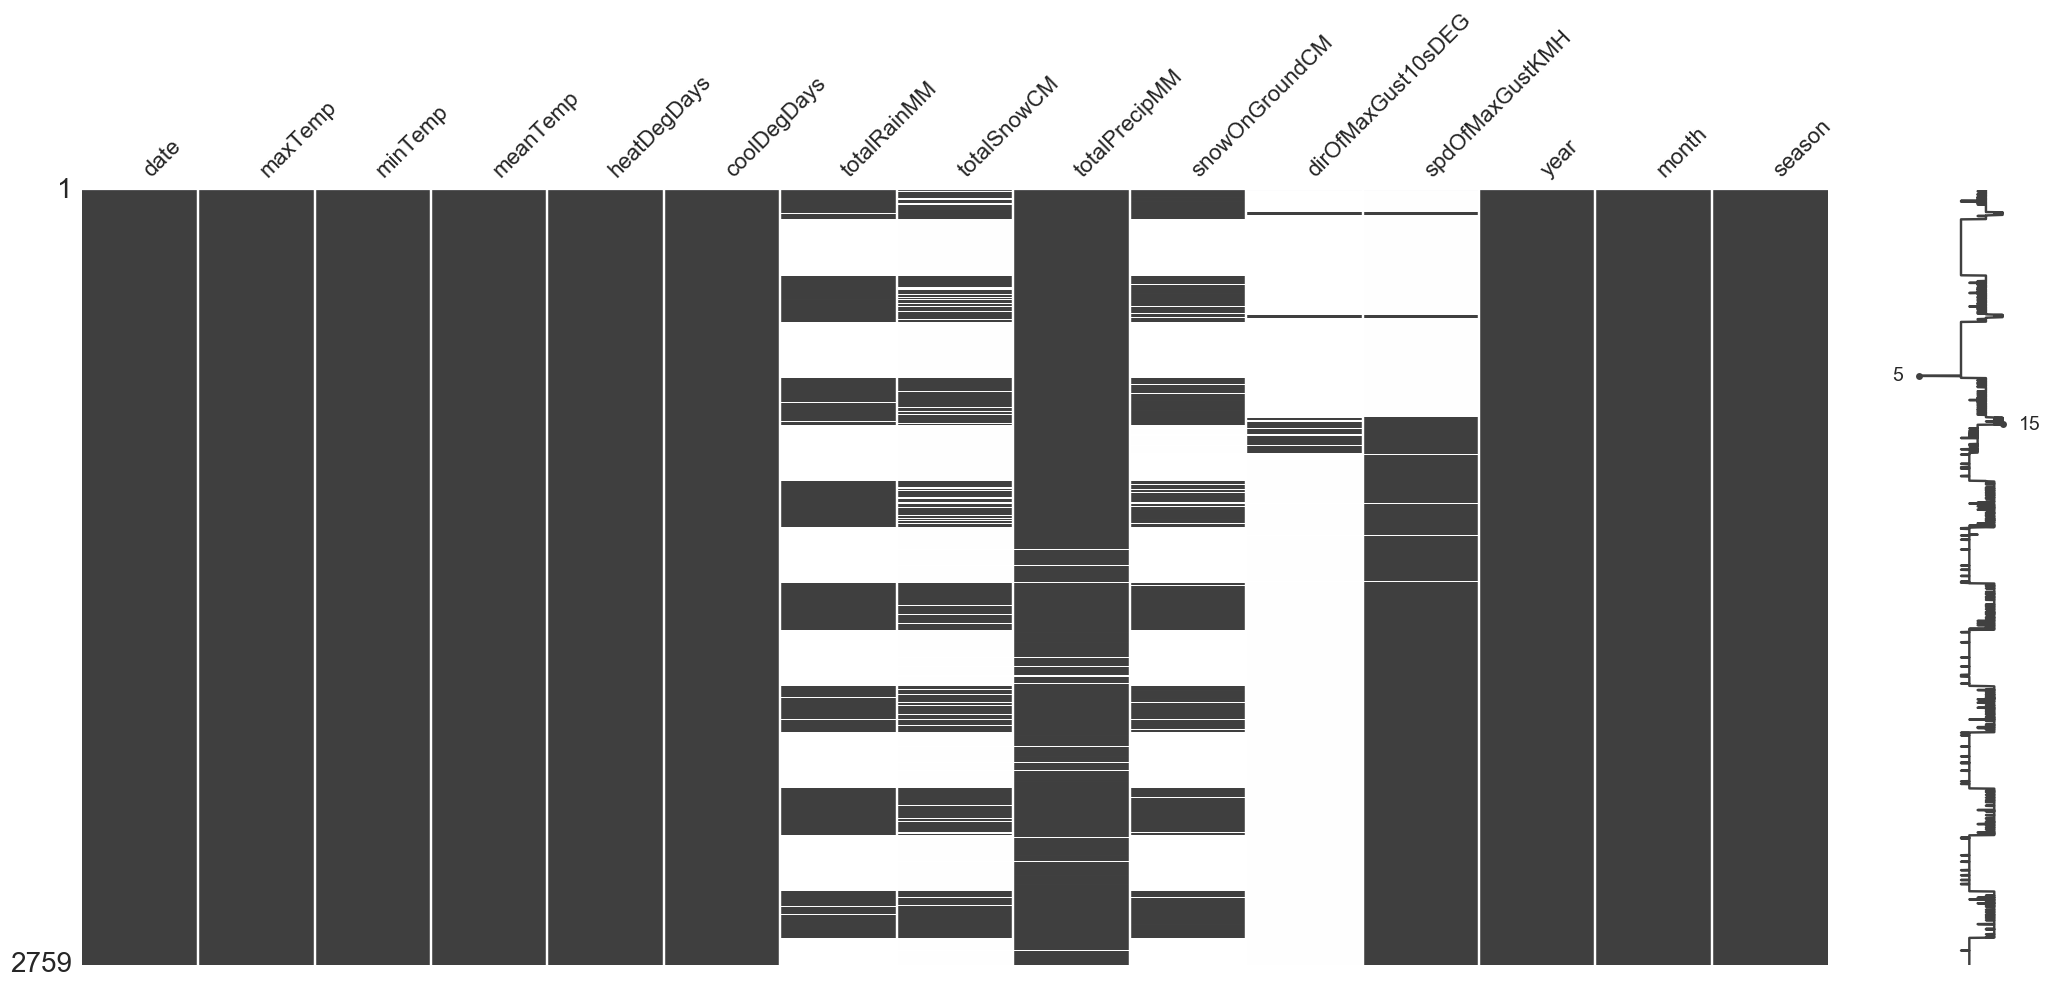

In [8]:
msno.matrix(df.sort_values('date', ascending=True))

Summary statistics for missing values:

In [43]:
max_missing_vars = df.isnull().sum(axis=1).sort_values(ascending=False).values[0]
max_missing_day = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False).head(1).index, 'date'].values[0]
max_missing_day_perc = int(round(max_missing_vars / len(df.columns) * 100, 0))
print("Number of variables: %s" % len(df.columns))
print("Highest number of missing values: {}/{}".format(max_missing_vars, len(df.columns)))
print("Highest % of missing measurements: {}".format(max_missing_day_perc))
print("Day with highest number of missing values: %s" % pd.to_datetime(max_missing_day).date())

Number of variables: 15
Highest number of missing values: 11/15
Highest % of missing measurements: 73
Day with highest number of missing values: 2017-08-25


Out of {{len(df)}} measurements, the maximum number of missing values for a day is {{max_missing_vars}} ({{max_missing_day_perc}}% of the variables) which was observed on {{str(pd.to_datetime(max_missing_day).date())}}.  We can safely ignore this single missing observation.

Since the data is sorted by date, rainfall and snowfall measurements look to be systematically missing but other variables look okay.  It makes sense to observe snowfall periodically since it usually only occurs in the winter but rain should be observed throughout year similar to precipitation (`totalPrecipMM`).

#### When is rainfall data missing?

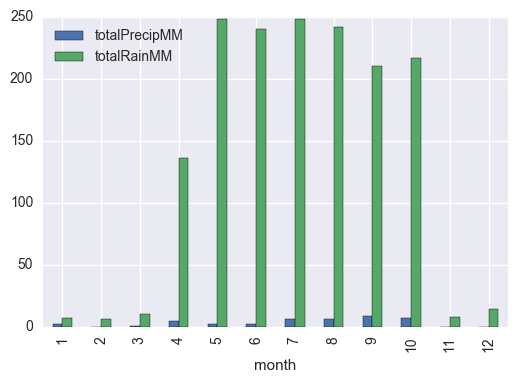

In [32]:
missing_df = df[['month', 'totalPrecipMM', 'totalRainMM']].groupby(
  ['month'])[['totalPrecipMM', 'totalRainMM']].apply(lambda x: pd.isnull(x).sum())
missing_df.plot(kind='bar');

In [30]:
missing_df

,totalPrecipMM,totalRainMM
month,,
1,2,7
2,0,6
3,1,10
4,5,136
5,2,248
6,2,240
7,6,248
8,6,242
9,9,210


#### Which months have the most missing precipitation records? 

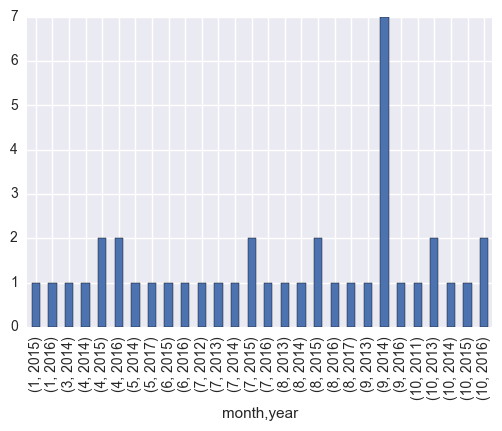

In [46]:
df[df.totalPrecipMM.isnull()].groupby(['month', 'year']).size().plot(kind='bar');

In [47]:
print("{:.0f}% of observations missing rainfall data".format(pd.isnull(df.totalRainMM).sum() / len(df)*100))
print("{:.0f}% of observations missing precipitation data".format(pd.isnull(df.totalPrecipMM).sum() / len(df)*100))

57% of observations missing rainfall data
1% of observations missing precipitation data


April through October (spring, summer, and fall months) are missing rain measurements year-over-year.  Although there is an overwhelming amount (57%) of missing rainfall observations, we can use precipitation measurements to infer rainfall.  

The [Rain Analysis and Count Modelling](#) provides more information about the missing values and handles them appropriately before continuing with further modelling efforts.

## 2.2 Multivariate Data Analysis
We'll look at the distributions of each variable simultaneously to evaluate distributions and relationships.  The table below describes statistical properties of the daily weather observations and the pair plot visualizes marginal and conditional distributions of the continuous (numerical) observations.

In [16]:
cont_vars = [
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
df[cont_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
minTemp,2759.0,3.423215,10.081919,-29.65,-3.3,3.500,11.7000,24.6
meanTemp,2758.0,8.394652,10.702823,-23.85,0.2,8.975,17.6875,30.7
maxTemp,2758.0,13.351994,11.609987,-18.90,3.6,14.550,23.7500,36.7
totalPrecipMM,2720.0,2.702463,6.161120,0.00,0.0,0.100,2.3500,69.7
totalRainMM,1208.0,1.585596,4.502499,0.00,0.0,0.000,0.2000,39.3


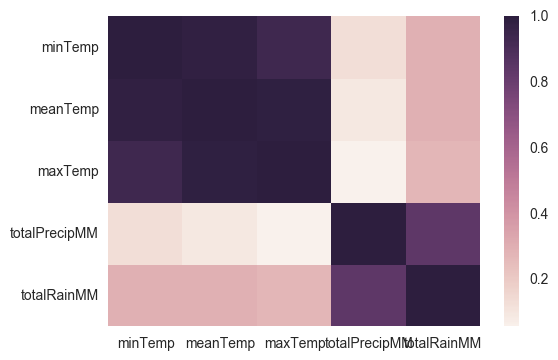

In [17]:
sns.heatmap(df[cont_vars].corr())

Strong correlation between temperature measurements and between precipitation/rain measurements

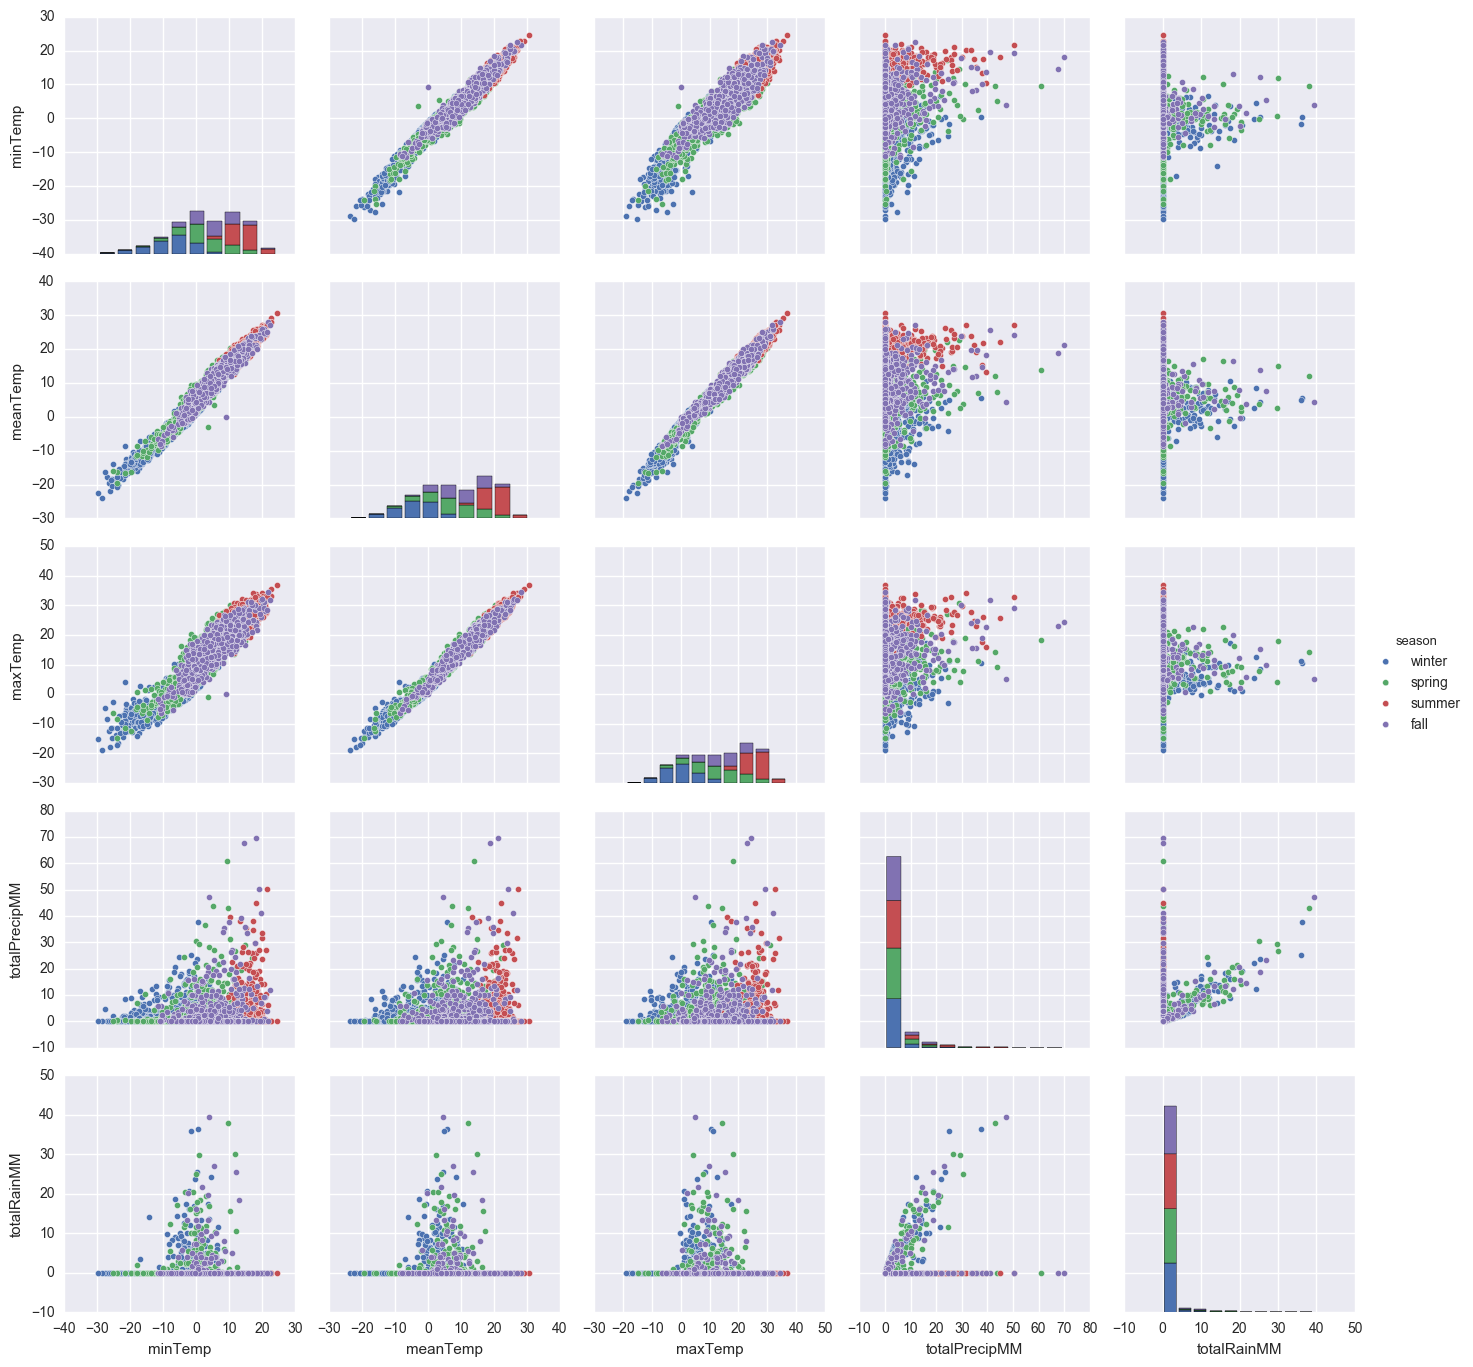

In [18]:
sns.pairplot(df[cont_vars].fillna(0), hue='season', size=2.75);

* Temperature distributions are bimodal, likely accounting for different seasons
* Precipitation is mildly correlated with precipitation i.e. higher temperatures correspond to more precipitation.  Intuitively, we usually observe more rainy days than snow days.  Both rain and snow are forms of precipitation.
* Precipitation appears to be [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) distributed

It would be interesting to examine days with large differences between minimum and maximum temperatures but it's out of scope for this analysis.

### Temperature and precipitation

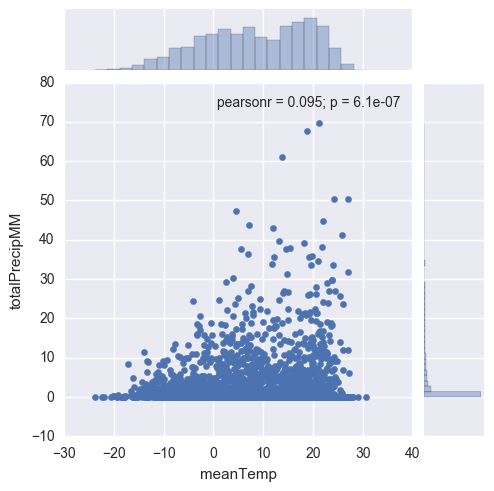

In [19]:
sns.jointplot(x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']], size=5);

Remove zeros

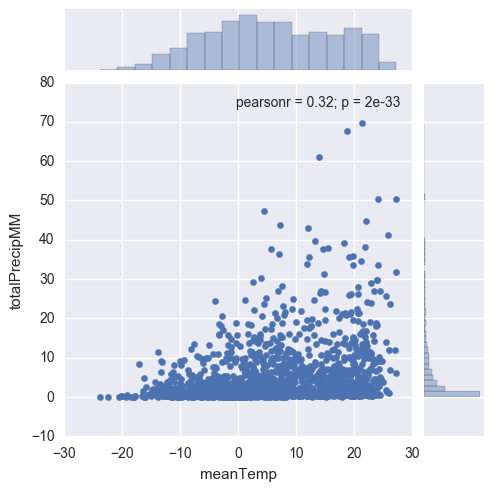

In [20]:
sns.jointplot(
  x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']].query('totalPrecipMM != 0'), size=5);

### Seasonal distributions

In [21]:
temp_cols = [
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp'
]

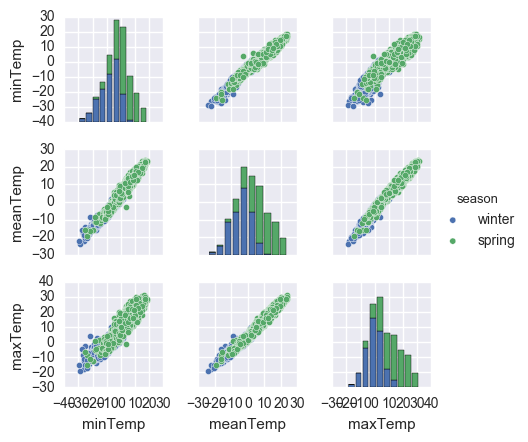

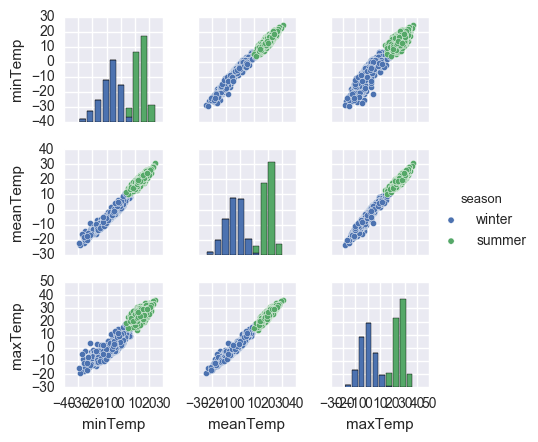

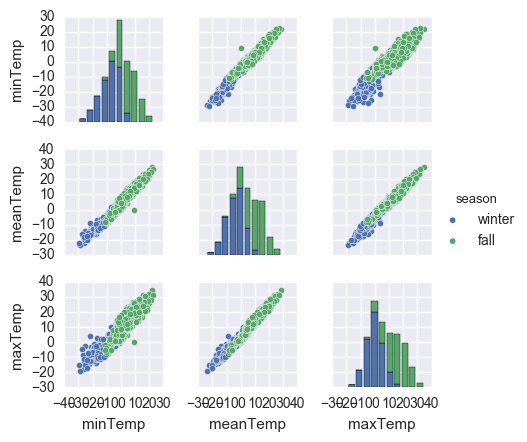

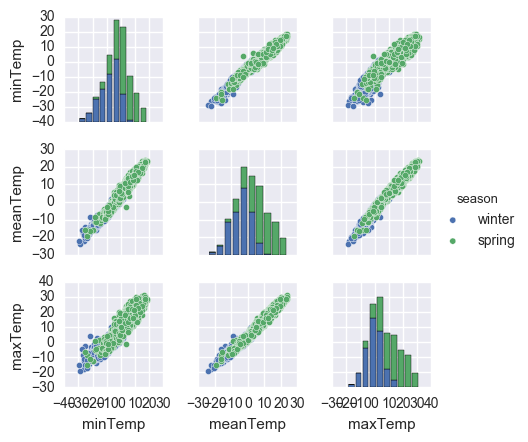

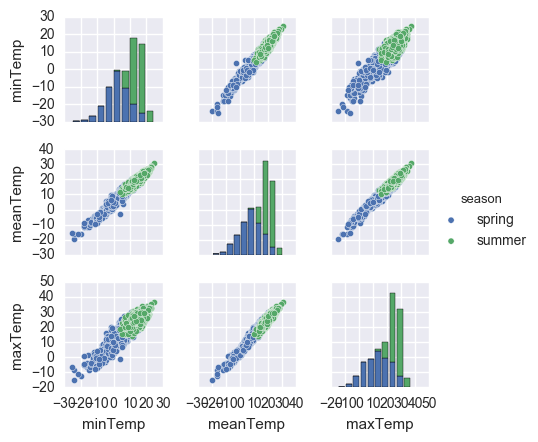

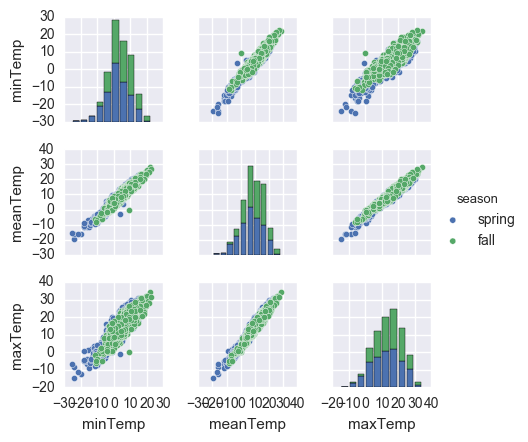

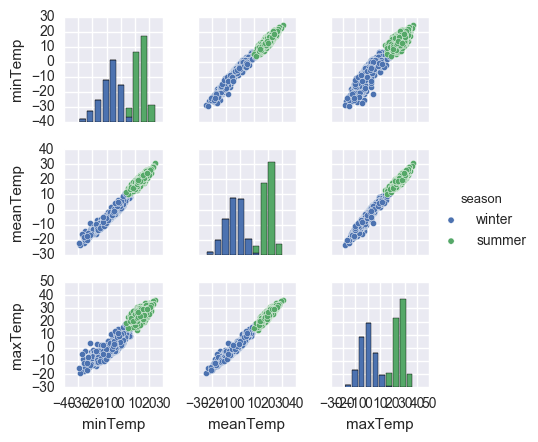

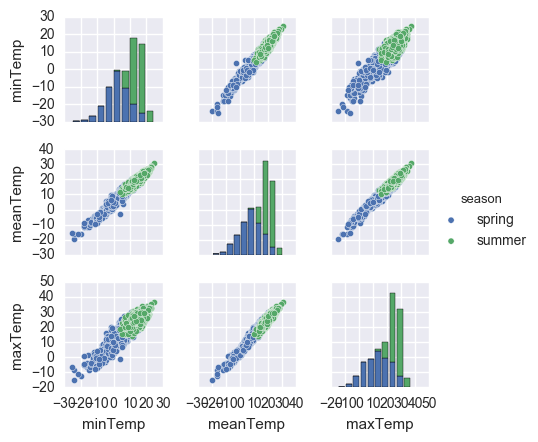

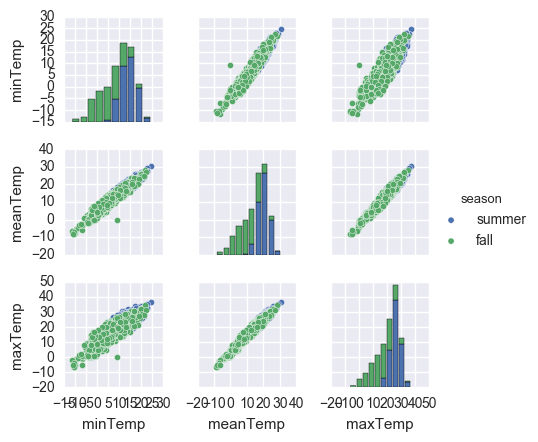

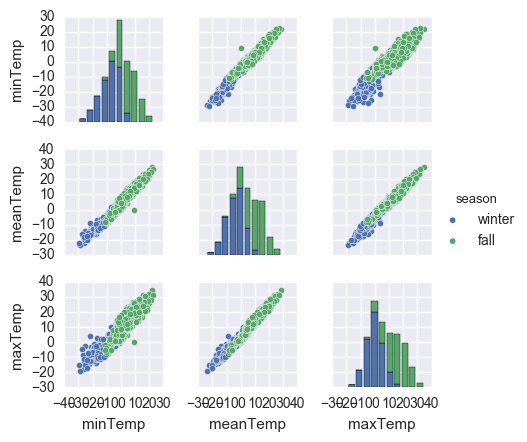

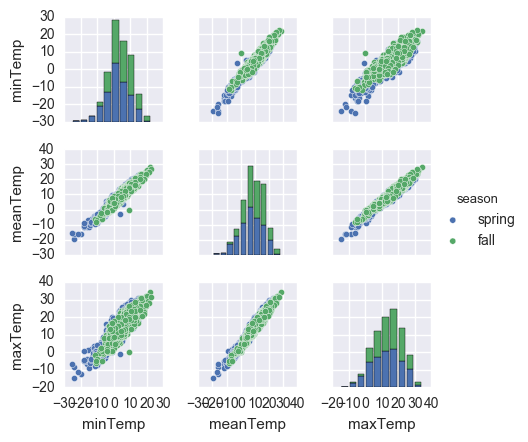

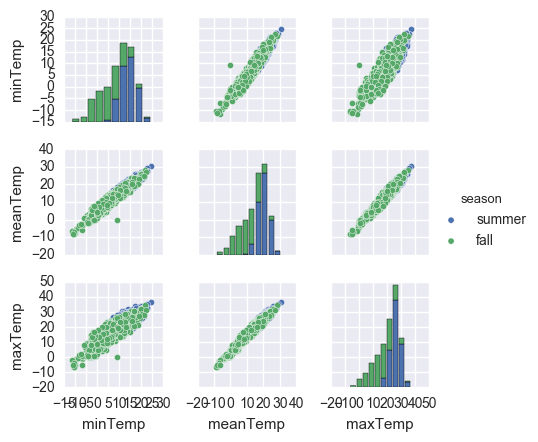

In [25]:
for x in filter(lambda x: x[0] != x[1], itertools.product(df.season.unique(), df.season.unique())):
  _ = sns.pairplot(df.loc[df.season.isin([x[0], x[1]]), temp_cols].fillna(0), hue='season', size=1.5)

As expected:
- Temperature distributions are normal/approximately normal
- Winter and spring, spring and summer, and spring and fall temperatures distributions overlap

## 2.3 Time Series Analysis

In [52]:
ts = df.set_index("date")
ts.head()

,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,season,year,month
date,,,,,,,,,,,,,,
2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,winter,2010,1
2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,winter,2010,1
2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,winter,2010,1
2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,winter,2010,1
2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,winter,2010,1


### Weekly

Temperature

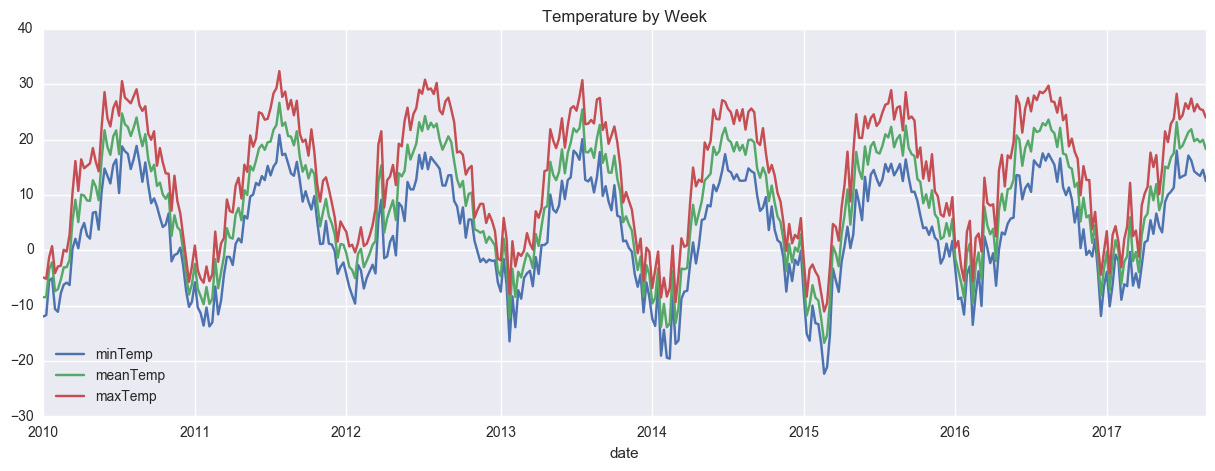

In [64]:
ts[['minTemp', 'meanTemp', 'maxTemp']].resample("1W").mean().plot(figsize=(15,5), title="Temperature by Week");

Precipitation

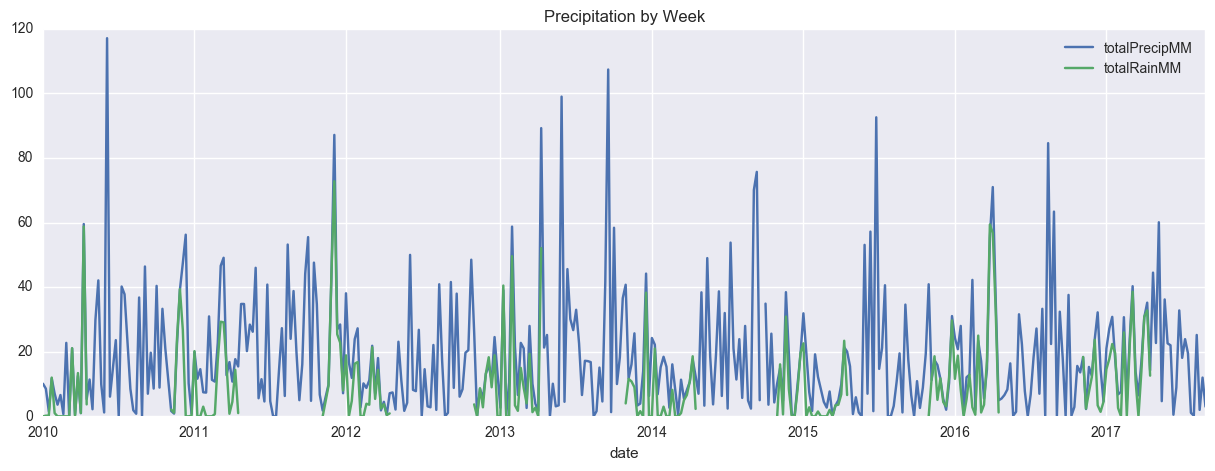

In [91]:
ts[['totalPrecipMM', 'totalRainMM']].resample("1W").sum().plot(figsize=(15,5), title="Precipitation by Week");

### Monthly

Average temperature

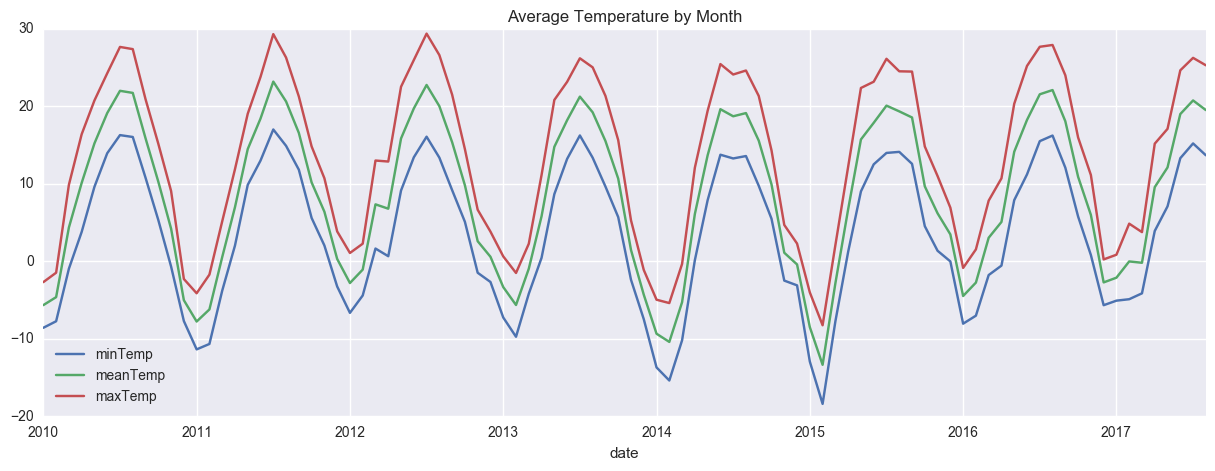

In [87]:
ts[['minTemp', 'meanTemp', 'maxTemp']].resample("1M").mean().plot(figsize=(15,5), title="Average Temperature by Month");

It looks like temperatures have been lower, on average, this year compared to last.

In [83]:
ts_temp = ts[['minTemp', 'meanTemp', 'maxTemp', 'year', 'month', 'season']]
ts_temp.head()

,minTemp,meanTemp,maxTemp,year,month,season
date,,,,,,
2010-01-01,-9.2,-4.6,0.0,2010,1,winter
2010-01-02,-14.1,-11.7,-9.2,2010,1,winter
2010-01-03,-12.6,-9.1,-5.6,2010,1,winter
2010-01-04,-11.2,-9.4,-7.5,2010,1,winter
2010-01-05,-8.9,-6.2,-3.5,2010,1,winter


In [99]:
ts_temp_grp = ts_temp[(ts_temp.year.isin([2016, 2017]) & (ts_temp.month.isin(range(1,9))))].groupby(['year', 'month'])
ts_temp_grp.meanTemp.describe().style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

In [100]:
ts_temp_grp = ts_temp[(ts_temp.year.isin([2016, 2017]) & (ts_temp.month.isin(range(1,9))))].groupby(['year', 'season'])
ts_temp_grp.meanTemp.describe().style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

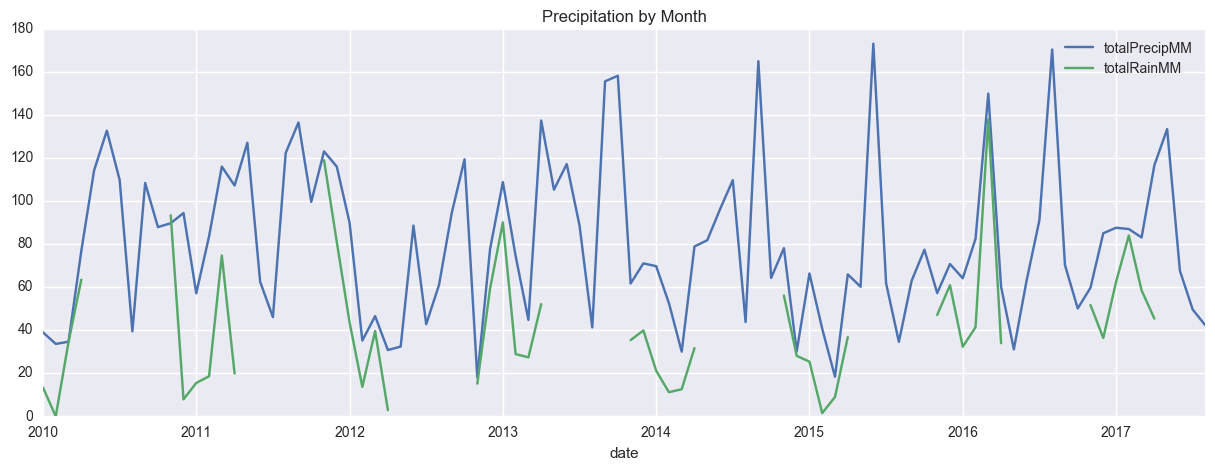

In [86]:
ts[['totalPrecipMM', 'totalRainMM']].resample("1M").sum().plot(figsize=(15,5), title="Total Precipitation by Month");

As we would expect, rainfall measurements correlate with precipitation measurements.  And there appear to be slight positive trends from 2012-2014 and 2015-2017.

In [101]:
ts_precip = ts[['totalPrecipMM', 'totalRainMM', 'year', 'month', 'season']]
ts_precip_grp = ts_precip[(ts_precip.year.isin([2016, 2017]) & (ts_precip.month.isin(range(1,9))))].groupby(['year', 'month'])
ts_precip_grp[['totalPrecipMM', 'totalRainMM']].describe().style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

In [102]:
ts_precip_grp = ts_precip[(ts_precip.year.isin([2016, 2017]) & (ts_precip.month.isin(range(1,9))))].groupby(['year', 'season'])
ts_precip_grp[['totalPrecipMM', 'totalRainMM']].describe().style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

Late winter and spring 2017 has experienced marginally more precipitation this year than last, on average.  So far, we've had, on average, less precipitation this summer than last.

### Yearly

Since 2017 is not complete, we'll use YTD (year to day) values to visualize precipitation change.

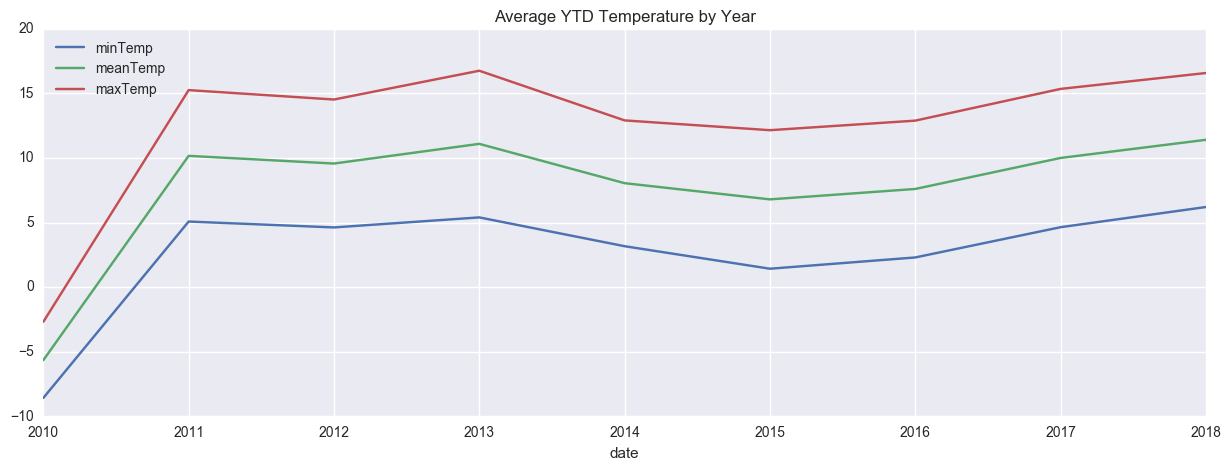

In [104]:
ts_temp_ytd = ts.query("month <= 8")[['minTemp', 'meanTemp', 'maxTemp']].resample("12M").mean()
ts_temp_ytd.plot(figsize=(15,5), title="Average YTD Temperature by Year");

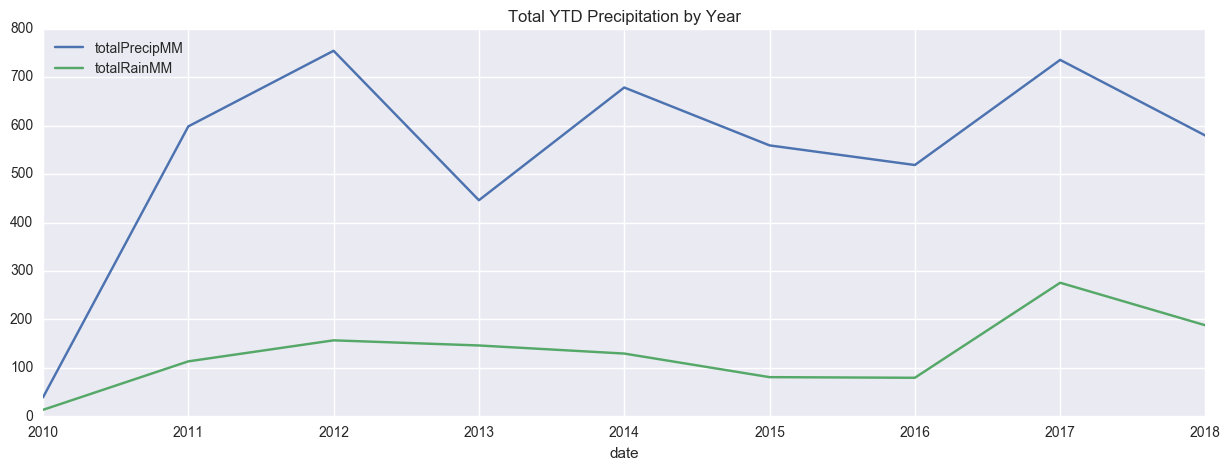

In [106]:
ts_temp_ytd = ts.query("month <= 8")[['totalPrecipMM', 'totalRainMM']].resample("12M").sum()
ts_temp_ytd.plot(figsize=(15,5), title="Total YTD Precipitation by Year");

There is clearly positive, increasing trend in mean observed temperature starting in 2015.  Precipitation exhibits some positive trend from 2013-217.

#### NOTES
* Normals available at http://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=4789&autofwd=1